In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-09-29 14:49:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2020-09-29 14:49:56 (112 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



Total number of stopwords :  153
Total number of sentences and labels :  2225
Training sentences   :  1780
Training labels      :  1780
Validation sentences :  445
Validation labels    :  445
Shape of train sequences      :  (1780, 120)
Shape of validation sequences :  (445, 120)
Example of sequence :  [454 466   3   6   1   1 465   4   1  49  85 442  37  10   1 935   1   1
  36   1  99   1 893  97   1  99   1   1  36  10   1   1   1   1   1   1
 671   1   1   1 587   1   1  12 894 671  65   1   2   1   1   1  99   1
 948   1   1 593   1  12  11   2 248   1  99 144   1 103 671   1   1  65
 534 688   1   1   1   1 497   1  45  13   1   1  99   1 688 282 126 252
   1 367 658  65   1 773   1   1 156   1 413   9  13  79   1   1 783 924
 128 599   1   1   1   1   1   9  13 907  85  85]
Shape of train labels      :  (1780, 1)
Shape of validation labels :  (445, 1)
The labels are :  {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
Model: "sequential_2"
_______________

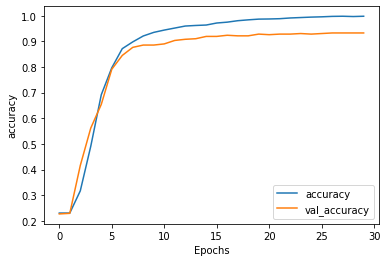

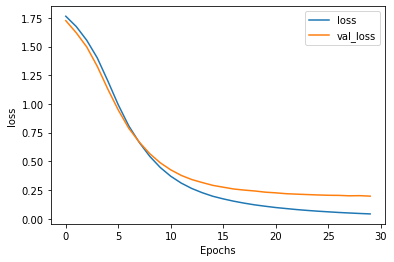

In [24]:
import csv

sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print("Total number of stopwords : ", len(stopwords))

with open("/tmp/bbc-text.csv", 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    labels.append(row[0])
    sentence = row[1]
    for word in stopwords:
      token = " " + word + " " 
      sentence = sentence.replace(token, " ")
    sentences.append(sentence)
print("Total number of sentences and labels : ", len(sentences))



split = .8
train_size = int(len(sentences) * split)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print("Training sentences   : ", len(train_sentences))
print("Training labels      : ", len(train_labels))
print("Validation sentences : ", len(validation_sentences))
print("Validation labels    : ", len(validation_labels))

#Hyperparameters
vocab_size = 1000
embedding_dim = 16
oov_tok = "<OOV>"
max_length = 120
padding_type = "post"
trunc_type = "post"

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sentence tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

print("Shape of train sequences      : ", train_padded.shape)
print("Shape of validation sequences : ", validation_padded.shape)
print("Example of sequence : ", train_padded[0])

# Label Tokenizer
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_word_index = label_tokenizer.word_index

train_label_sequences = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_sequences = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print("Shape of train labels      : ", train_label_sequences.shape)
print("Shape of validation labels : ", validation_label_sequences.shape)
print("The labels are : ", label_word_index)

# Model
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation="relu"),
                             tf.keras.layers.Dense(6, activation="softmax")
])

model.summary()
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
num_epochs = 30
history = model.fit(train_padded, train_label_sequences,
                    epochs=num_epochs,
                    validation_data=(validation_padded, validation_label_sequences))

import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = model.layers[0]
weights = e.get_weights()[0]

import io 

out_v = io.open("vecs_bbc.tsv", 'w', encoding="utf-8")
out_m = io.open("meta_bbc.tsv", 'w', encoding="utf-8")
for word_num in range(1,vocab_size):
    word = reverse_word_index[word_num]
    embedding = weights[word_num]
    out_m.write(word+"\n")
    out_v.write("\t".join([str(val) for val in embedding]) + "\n")
out_v.close()
out_m.close()

In [28]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs_bbc.tsv')
    files.download('meta_bbc.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>